In [186]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.spatial import distance_matrix

number_cities = 10
x_max         = 100000    # maximum coordinates of a city on the x axis
y_max         = 100000    # maximum coordinates of a city on the y axis

coords        = np.random.randint([x_max, y_max], size=(number_cities, 2))  # Creation of a random matrix of city coordinates

print(coords)

[[23417 10591]
 [97193 40523]
 [14431 82261]
 [75635 45733]
 [32690 20280]
 [74621 21520]
 [71339 27187]
 [64175 83669]
 [ 8757  1957]
 [16287 47078]]


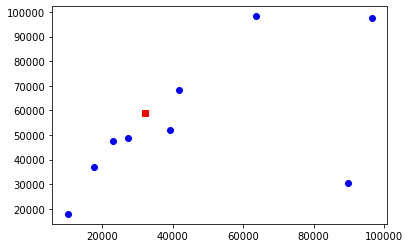

In [53]:
x, y = coords.T                             # We define that the first value of coords is X and the second is Y
plt.plot(x[0], y[0], c='r', marker='s')
plt.scatter(x[1:],y[1:], c='b')             # Put the x and y axis in pyplot
plt.show()                                  # Display the coordinates of the cities on an orthonormal coordinate system

In [187]:

'''
Generate city names in alphabetical order
'''
cities = []

for i in range(number_cities):
    city = chr(ord('A') + i)
    cities.append(city)

'''
Creation of the matrix of distances between cities
'''

df       = pd.DataFrame(coords, columns=['xcord', 'ycord'],    index=cities)
matrix   = distance_matrix(df.values, df.values)
distance = pd.DataFrame(matrix, index=df.index, columns=df.index)

print(df)
print(distance)

   xcord  ycord
A  23417  10591
B  97193  40523
C  14431  82261
D  75635  45733
E  32690  20280
F  74621  21520
G  71339  27187
H  64175  83669
I   8757   1957
J  16287  47078
              A             B             C             D             E  \
A      0.000000  79616.724374  72231.136610  62941.875473  13411.385089   
B  79616.724374      0.000000  92690.934228  22178.626287  67604.852326   
C  72231.136610  92690.934228      0.000000  71275.692911  64614.514174   
D  62941.875473  22178.626287  71275.692911      0.000000  49921.220278   
E  13411.385089  67604.852326  64614.514174  49921.220278      0.000000   
F  52357.355329  29506.087389  85512.017758  24234.223012  41949.330877   
G  50714.350040  29090.861314  79193.850393  19037.062063  39261.327665   
H  83675.615612  54330.154058  49763.922675  39629.177332  70777.613311   
I  17013.569761  96479.336917  80504.202946  79931.252086  30141.679084   
J  37177.117546  81171.108536  35231.920541  59363.238869  31419.599186   

In [188]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from time import time


class VPR:

    def __init__(self, n_trucks, dimension, capacity, demands, adj_matrix):
        self.n_trucks = n_trucks
        self.dimension = dimension
        self.capacity = capacity
        self.demands = demands
        self.adj_matrix = adj_matrix
        self.adj_matrix_sum = adj_matrix.sum()
        self.final_cost = self.adj_matrix_sum
        self.final_sol = None

        self.epochs = None
        self.n_ants = None
        self.alpha = None
        self.beta = None
        self.rho = None
        self.init_pheromone_value = None
        self.pheromone_map = None
        self.raw_prob_matrix = None
        self.tabu = None
        self.tabu_sum = None
        self.capacity_left = None

    def get_probality(self, raw_prob_list):
        prob_list = raw_prob_list/raw_prob_list.sum()
        return prob_list

    def get_next_vertex(self, pos):
        potential = deepcopy(self.tabu)
        potential_sum = self.tabu_sum
        while potential_sum < self.dimension:
            raw_prob_list = deepcopy(self.raw_prob_matrix[pos]) * potential
            next_vertex = np.random.choice(np.arange(0, self.dimension), p=self.get_probality(raw_prob_list))
            if self.demands[next_vertex] <= self.capacity_left:
                return next_vertex
            potential[next_vertex] = 0
            potential_sum += 1
        return 0

    def local_update(self, i, j):
        self.pheromone_map[i, j] += self.rho * self.init_pheromone_value / self.adj_matrix[i, j]
        self.pheromone_map[j, i] = self.pheromone_map[i, j]
        self.raw_prob_matrix[i, j] = self.raw_prob_matrix[j, i] = (self.pheromone_map[i, j] ** self.alpha) * \
                                                                  ((1 / self.adj_matrix[i, j]) ** self.beta)

    def global_update(self, best_solution, best_cost):
        for one_path in best_solution:
            for i in range(len(one_path)-1):
                self.pheromone_map[one_path[i], one_path[i + 1]] += self.rho * self.capacity / best_cost
                self.pheromone_map[one_path[i + 1], one_path[i]] = self.pheromone_map[one_path[i], one_path[i + 1]]
                self.raw_prob_matrix[one_path[i], one_path[i + 1]] = \
                    self.raw_prob_matrix[one_path[i + 1], one_path[i]] = \
                    (self.pheromone_map[one_path[i], one_path[i + 1]] ** self.alpha) * \
                    ((1 / self.adj_matrix[one_path[i], one_path[i + 1]]) ** self.beta)

    def get_cost(self, solution):
        current_cost = 0
        for i in range(len(solution) - 1):
            current_cost += self.adj_matrix[solution[i], solution[i + 1]]
        return current_cost

    def plot_function(self):
        box = {'facecolor': 'white',
               'edgecolor': 'black',
               'boxstyle': 'round'}
        plt.figure(figsize=(9.5, 6))
        plt.text(self.epochs - 18, self.show_epoch[4] - 60,
                 f'cost={round(self.final_cost, 2)}, \n'
                 f'epochs={self.epochs}, \n'
                 f'n_ants={self.n_ants}, \n'
                 f'alpha={self.alpha}, \n'
                 f'beta={self.beta}, \n'
                 f'p={self.rho}, \n'
                 f'init_ph={self.init_pheromone_value}',
                 bbox=box, color='black', fontsize=12)
        plt.plot(np.arange(self.epochs), self.show_cost, 'r')
        plt.plot(np.arange(self.epochs), self.show_epoch, 'k')
        plt.grid()
        plt.title(f'Fitness function for A-n{self.dimension}-k{self.n_trucks}', fontsize=18)
        plt.xlabel('epoch')
        plt.ylabel('cost')
        plt.show()

    def compute(self, epochs=100, n_ants=50, alpha=1.5, beta=0.3, rho=0.95, init_pheromone=1000):
        self.epochs = epochs
        self.n_ants = n_ants
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.init_pheromone_value = init_pheromone
        self.pheromone_map = np.full(shape=(self.dimension, self.dimension), fill_value=self.init_pheromone_value)
        np.fill_diagonal(self.pheromone_map, 0)

        np.fill_diagonal(self.adj_matrix, 0.1)
        self.raw_prob_matrix = (self.pheromone_map ** self.alpha) * ((1 / self.adj_matrix) ** self.beta)
        np.fill_diagonal(self.adj_matrix, 0)

        self.show_epoch = []
        self.show_cost = []
        for epoch in range(self.epochs):
            time_s = time()
            best_solution = None
            best_cost = self.adj_matrix_sum
            for ant in range(self.n_ants):
                current_state = 0
                solutions = []
                one_path_solution = [0]
                self.capacity_left = self.capacity
                self.tabu = np.ones(self.dimension)
                self.tabu[0] = 0
                self.tabu_sum = 1
                while self.tabu_sum < self.dimension:
                    next_state = self.get_next_vertex(current_state)
                    if next_state == 0:
                        one_path_solution.append(0)
                        solutions.append(one_path_solution)
                        one_path_solution = [0]
                        current_state = 0
                        self.capacity_left = self.capacity
                        continue
                    one_path_solution.append(next_state)
                    self.capacity_left -= self.demands[next_state]
                    self.local_update(current_state, next_state)
                    current_state = next_state
                    self.tabu[current_state] = 0
                    self.tabu_sum += 1

                one_path_solution.append(0)
                solutions.append(one_path_solution)
                cost = sum([self.get_cost(sol) for sol in solutions])

                assert all(np.unique(np.hstack(solutions)) == np.arange(self.dimension))

                if cost < best_cost:
                    best_cost = cost
                    best_solution = solutions

            self.global_update(best_solution, best_cost)
            self.show_epoch.append(best_cost)
            if self.final_cost > best_cost:
                self.final_cost = best_cost
                self.final_sol = best_solution
                self.show_cost.append(self.final_cost)
            else:
                self.show_cost.append(self.show_cost[-1])
            # print(f'Epoch: {epoch} | time: {round(time() - time_s, 4)}| best cost: {best_cost}')

        self.final_sol = [(np.array(x) + 1).tolist() for x in self.final_sol]

In [192]:
car_number                       =  1
distance_ant                     =  matrix
distance_ant[distance_ant == 0]  =  np.inf

capacity                         =  30
dimension                        =  number_cities
asj_matrix                       =  coords
demands                          =  [10 ,10 ,10 ,10 ,10 ,10 ,10 ,10 ,10 ,10,
                                     10 ,10 ,10 ,10 ,10 ,10 ,10 ,10 ,10 ,10,
                                     10 ,10 ,10 ,10 ,10 ,10 ,10 ,10 ,10 ,10,
                                     10 ,10 ,10 ,10 ,10 ,10 ,10, 10, 10, 10]

adj_matrix                       =  matrix

case = VPR(car_number, dimension, capacity, demands, adj_matrix)
case.compute(epochs=300, n_ants=100, alpha=1, beta=1, rho=0.95, init_pheromone=1000)

print(f'Found solution:')
test534 = case.final_sol
display(case.final_sol)

Found solution:


[[1, 7, 2, 6, 1], [1, 4, 8, 3, 1], [1, 5, 10, 9, 1]]

Couple :  0 6
Couple :  6 1
Couple :  1 5
Couple :  5 0
---------------------
Couple :  0 3
Couple :  3 7
Couple :  7 2
Couple :  2 0
---------------------
Couple :  0 4
Couple :  4 9
Couple :  9 8
Couple :  8 0
---------------------


<function matplotlib.pyplot.show(close=None, block=None)>

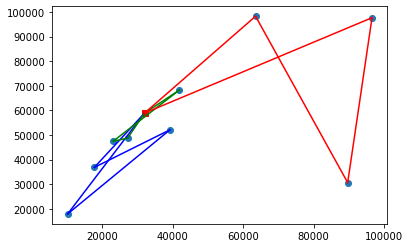

In [193]:
plt.scatter(x[0], y[0], c='r', marker='s')
plt.scatter(x[1:], y[1:])
col = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
i   = 0
  
for truck in test534:
    for test in range(len(truck)-1):
        dot1 = truck[test]-1
        dot2 = truck[test+1]-1
        print("Couple : ", dot1, dot2)
        plt.plot([x[dot1], x[dot2]], [y[dot1], y[dot2]], c=col[(i) % len(col)])
    i += 1
    print("---------------------")
plt.show

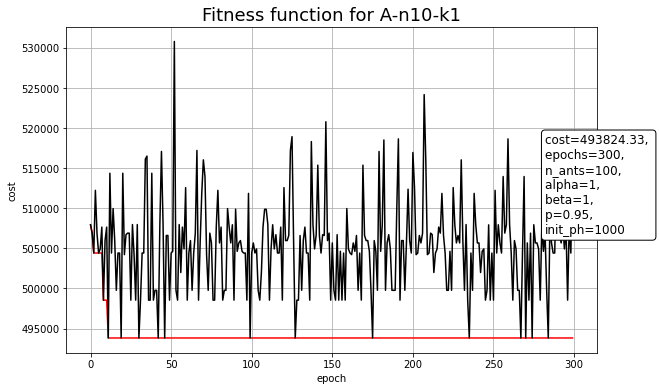

In [194]:
case.plot_function()

In [184]:
import folium

m = folium.Map(location=[43.652597, -79.384669], tiles="CartoDB positron", zoom_start=13)

depot_longitude       =  -79.383292
depot_latitude        =  43.652224
customer_count        =  10

#coords_long_lat       = np.random.randint(low=[latitude_min, latitude_max], high=[longitude_max, latitude_max], size=(number_cities, 2))

demand = np.random.randint(1, 11, customer_count-1)
demand = np.insert(demand,0,0)
print(demand)

df_map = pd.DataFrame({"longitude":np.random.normal(depot_longitude, 0.008, customer_count),
                       "latitude":np.random.normal(depot_latitude, 0.008, customer_count),
                       "demand":demand})



print(df_map)

[0 4 1 7 3 4 1 8 3 1]
   longitude   latitude  demand
0 -79.382308  43.655015       0
1 -79.391781  43.650117       4
2 -79.370821  43.639906       1
3 -79.385811  43.650155       7
4 -79.377471  43.655530       3
5 -79.365450  43.651815       4
6 -79.394048  43.652695       1
7 -79.384394  43.652707       8
8 -79.396484  43.661099       3
9 -79.392092  43.655740       1


In [203]:
m = folium.Map(location=[43.652597, -79.384669], tiles="CartoDB positron", zoom_start=13)
m
for index, row in df_map.iterrows():
    icon_house = "circle"
    color      = "blue"
    if index == 0:
        icon_house = "home"
        color      = "red"
    popup_demand = "Demand: " + str(row['demand'])
    folium.Marker(location=[row['latitude'], row['longitude']], tooltip="click for more", popup = popup_demand, icon=folium.Icon(color=color ,icon=icon_house, prefix='fa')).add_to(m)
m

In [204]:
col = ['blue', 'green', 'red', 'pink', 'orange', 'yellow', 'black', 'brown']
i   = 0


for truck in test534:
    for test in range(len(truck)-1):
        dot1 = truck[test]-1
        dot2 = truck[test+1]-1
        dot1_loc = df_map.iloc[dot1]
        dot2_loc = df_map.iloc[dot2]
        test5465['longitude']

        line = [(dot1_loc['latitude'],dot1_loc['longitude']), (dot2_loc['latitude'],dot2_loc['longitude'])]
        
        folium.PolyLine(line,
                color=col[(i) % len(col)],
                weight=15,
                opacity=0.8).add_to(m)
    i += 1

m